### **This test case will use UCF101 Action Recognition Data Set to verify:**

*    the performance of **ISI encoder Scheme**.



In [ ]:
!pip install remotezip tqdm opencv-python einops
!pip install tensorflow keras

In [ ]:
import tqdm
import random
import pathlib
import itertools
import collections

import cv2
import einops
import numpy as np
import remotezip as rz
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras import layers
import time

In [ ]:
import keras
from keras.models import Sequential
from keras.datasets import mnist
from keras.layers import Dense
from keras import initializers
from keras.regularizers import l2
from keras.layers import Flatten
from keras.layers import Conv1D
from keras.layers import Dropout
from keras.optimizers import Adam
#because of multiclass datasets
from tensorflow.keras import utils
import random

**Load and preprocess video data**


In [ ]:
import tensorflow as tf

def ISI_encode(video, time_steps=20, min_interval=1.0, max_interval=10.0):
    """
    Convert a video (frames, H, W, C) into Interspike Interval (ISI) spike trains.

    Args:
        video: Tensor or numpy array of shape (frames, H, W, C), values in [0,1].
        time_steps: Number of discrete time steps to encode over.
        min_interval: Minimum ISI (for brightest pixel).
        max_interval: Maximum ISI (for darkest pixel).

    Returns:
        spikes: Binary tensor of shape (time_steps, frames, H, W, C)
                indicating spikes over time.
    """
    # Ensure input is a tensor
    video = tf.convert_to_tensor(video, dtype=tf.float32)

    # Map intensity to ISI duration: bright → shorter interval, dark → longer interval
    ISI = max_interval - video * (max_interval - min_interval)  # same shape as video

    # Initialize spike tensor
    spikes = tf.zeros((time_steps, *video.shape), dtype=tf.float32)

    # Initialize phase (accumulated time until next spike)
    phase = tf.zeros_like(video, dtype=tf.float32)

    # Simulate time evolution
    for t in range(time_steps):
        # When phase reaches/exceeds ISI, fire a spike
        spike_mask = tf.cast(tf.greater_equal(phase, ISI), tf.float32)

        # Record spikes
        spikes = tf.tensor_scatter_nd_update(
            spikes,
            tf.constant([[t]]),  # current time step
            tf.expand_dims(spike_mask, axis=0)
        ) if t == 0 else tf.concat(
            [spikes[:t], tf.expand_dims(spike_mask, axis=0), spikes[t+1:]], axis=0
        )

        # Reset phase where spike occurred
        phase = tf.where(spike_mask > 0, 0.0, phase)

        # Increment phase for all pixels
        phase += 1.0

    return spikes


/tmp/ipython-input-1704818457.py:103: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


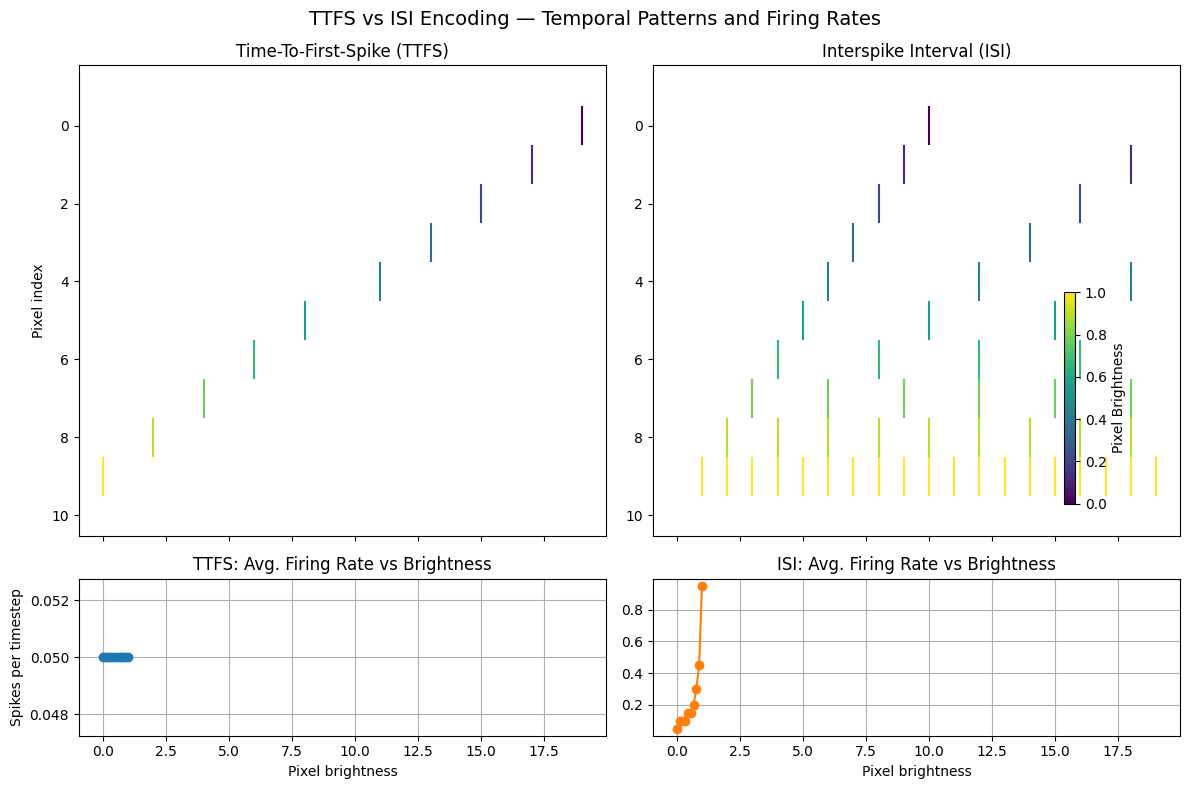

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# TTFS Encoder
# -------------------------------
def TTFS_encode(video, time_steps=20):
    """Time-To-First-Spike encoder: bright pixels fire earlier, only once."""
    video = tf.convert_to_tensor(video, dtype=tf.float32)
    spike_times = (1.0 - video) * (time_steps - 1)
    spike_times = tf.round(spike_times)
    time_range = tf.range(time_steps, dtype=tf.float32)[:, None, None, None, None]
    spikes = tf.cast(tf.equal(time_range, spike_times[None, ...]), tf.float32)
    return spikes  # shape: (time_steps, frames, H, W, C)


# -------------------------------
# ISI Encoder
# -------------------------------
def ISI_encode(video, time_steps=20, min_interval=1.0, max_interval=10.0):
    """Interspike Interval encoder: bright pixels fire more frequently."""
    video = tf.convert_to_tensor(video, dtype=tf.float32)
    ISI = max_interval - video * (max_interval - min_interval)
    spikes = []
    phase = tf.zeros_like(video, dtype=tf.float32)
    for t in range(time_steps):
        spike_mask = tf.cast(tf.greater_equal(phase, ISI), tf.float32)
        spikes.append(spike_mask)
        phase = tf.where(spike_mask > 0, 0.0, phase)
        phase += 1.0
    return tf.stack(spikes, axis=0)


# -------------------------------
# Comparison Demo
# -------------------------------
input_x = np.linspace(0.0, 1.0, num=10).reshape((10, 1, 1, 1))
time_steps = 20

TTFS_spike_plot = np.zeros((10, time_steps))
ISI_spike_plot = np.zeros((10, time_steps))

for i in range(10):
    ttfs_spikes = TTFS_encode(input_x[i], time_steps)
    isi_spikes = ISI_encode(input_x[i], time_steps)
    TTFS_spike_plot[i, :] = tf.squeeze(ttfs_spikes).numpy()
    ISI_spike_plot[i, :] = tf.squeeze(isi_spikes).numpy()

# Collect spike event times
TTFS_events = [np.where(TTFS_spike_plot[i] > 0)[0] for i in range(10)]
ISI_events = [np.where(ISI_spike_plot[i] > 0)[0] for i in range(10)]

# Color mapping based on brightness
brightness = input_x.squeeze()  # [0,1]
cmap = plt.cm.viridis
colors = [cmap(b) for b in brightness]

# -------------------------------
# Plot Layout: 2x2 grid
# -------------------------------
fig, axes = plt.subplots(2, 2, figsize=(12, 8), gridspec_kw={'height_ratios': [3, 1]}, sharex='col')

# TTFS Event Plot
axes[0, 0].eventplot(TTFS_events, colors=colors)
axes[0, 0].set_title("Time-To-First-Spike (TTFS)")
axes[0, 0].set_ylabel("Pixel index")
axes[0, 0].invert_yaxis()

# ISI Event Plot
axes[0, 1].eventplot(ISI_events, colors=colors)
axes[0, 1].set_title("Interspike Interval (ISI)")
axes[0, 1].invert_yaxis()

# -------------------------------
# Firing Rate Calculation
# -------------------------------
# Average spikes per pixel
TTFS_rate = np.sum(TTFS_spike_plot, axis=1) / time_steps
ISI_rate = np.sum(ISI_spike_plot, axis=1) / time_steps

# -------------------------------
# Firing Rate Curves
# -------------------------------
axes[1, 0].plot(brightness, TTFS_rate, marker='o', color='C0')
axes[1, 0].set_title("TTFS: Avg. Firing Rate vs Brightness")
axes[1, 0].set_xlabel("Pixel brightness")
axes[1, 0].set_ylabel("Spikes per timestep")
axes[1, 0].grid(True)

axes[1, 1].plot(brightness, ISI_rate, marker='o', color='C1')
axes[1, 1].set_title("ISI: Avg. Firing Rate vs Brightness")
axes[1, 1].set_xlabel("Pixel brightness")
axes[1, 1].grid(True)

# Colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])
cbar = fig.colorbar(sm, ax=axes[:, 1], orientation="vertical", fraction=0.025, pad=0.04)
cbar.set_label("Pixel Brightness")

plt.suptitle("TTFS vs ISI Encoding — Temporal Patterns and Firing Rates", fontsize=14)
plt.tight_layout()
plt.show()


In [ ]:
def list_files_per_class(zip_url):
  """
    List the files in each class of the dataset given the zip URL.

    Args:
      zip_url: URL from which the files can be unzipped.

    Return:
      files: List of files in each of the classes.
  """
  files = []
  with rz.RemoteZip(URL) as zip:
    for zip_info in zip.infolist():
      files.append(zip_info.filename)
  return files

def get_class(fname):
  """
    Retrieve the name of the class given a filename.

    Args:
      fname: Name of the file in the UCF101 dataset.

    Return:
      Class that the file belongs to.
  """
  return fname.split('_')[-3]

def get_files_per_class(files):
  """
    Retrieve the files that belong to each class.

    Args:
      files: List of files in the dataset.

    Return:
      Dictionary of class names (key) and files (values).
  """
  files_for_class = collections.defaultdict(list)
  for fname in files:
    class_name = get_class(fname)
    files_for_class[class_name].append(fname)
  return files_for_class

def download_from_zip(zip_url, to_dir, file_names):
  """
    Download the contents of the zip file from the zip URL.

    Args:
      zip_url: Zip URL containing data.
      to_dir: Directory to download data to.
      file_names: Names of files to download.
  """
  with rz.RemoteZip(zip_url) as zip:
    for fn in tqdm.tqdm(file_names):
      class_name = get_class(fn)
      zip.extract(fn, str(to_dir / class_name))
      unzipped_file = to_dir / class_name / fn

      fn = pathlib.Path(fn).parts[-1]
      output_file = to_dir / class_name / fn
      unzipped_file.rename(output_file,)

def split_class_lists(files_for_class, count):
  """
    Returns the list of files belonging to a subset of data as well as the remainder of
    files that need to be downloaded.

    Args:
      files_for_class: Files belonging to a particular class of data.
      count: Number of files to download.

    Return:
      split_files: Files belonging to the subset of data.
      remainder: Dictionary of the remainder of files that need to be downloaded.
  """
  split_files = []
  remainder = {}
  for cls in files_for_class:
    split_files.extend(files_for_class[cls][:count])
    remainder[cls] = files_for_class[cls][count:]
  return split_files, remainder

def download_ufc_101_subset(zip_url, num_classes, splits, download_dir):
  """
    Download a subset of the UFC101 dataset and split them into various parts, such as
    training, validation, and test.

    Args:
      zip_url: Zip URL containing data.
      num_classes: Number of labels.
      splits: Dictionary specifying the training, validation, test, etc. (key) division of data
              (value is number of files per split).
      download_dir: Directory to download data to.

    Return:
      dir: Posix path of the resulting directories containing the splits of data.
  """
  files = list_files_per_class(zip_url)
  for f in files:
    tokens = f.split('/')
    if len(tokens) <= 2:
      files.remove(f) # Remove that item from the list if it does not have a filename

  files_for_class = get_files_per_class(files)

  classes = list(files_for_class.keys())[:num_classes]

  for cls in classes:
    new_files_for_class = files_for_class[cls]
    random.shuffle(new_files_for_class)
    files_for_class[cls] = new_files_for_class

  # Only use the number of classes you want in the dictionary
  files_for_class = {x: files_for_class[x] for x in list(files_for_class)[:num_classes]}

  dirs = {}
  for split_name, split_count in splits.items():
    print(split_name, ":")
    split_dir = download_dir / split_name
    split_files, files_for_class = split_class_lists(files_for_class, split_count)
    download_from_zip(zip_url, split_dir, split_files)
    dirs[split_name] = split_dir

  return dirs

def format_frames(frame, output_size):
  """
    Pad and resize an image from a video.

    Args:
      frame: Image that needs to resized and padded.
      output_size: Pixel size of the output frame image.

    Return:
      Formatted frame with padding of specified output size.
  """
  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)
  return frame

def frames_from_video_file(video_path, n_frames, output_size = (50,50), frame_step = 15):
  """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
  """
  # Read each video frame by frame
  result = []
  src = cv2.VideoCapture(str(video_path))

  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

  need_length = 1 + (n_frames - 1) * frame_step

  if need_length > video_length:
    start = 0
  else:
    max_start = int(video_length - need_length)
    start = random.randint(0, int(max_start + 1)) # Cast to int


  src.set(cv2.CAP_PROP_POS_FRAMES, start)
  # ret is a boolean indicating whether read was successful, frame is the image itself
  ret, frame = src.read()
  if ret:
      # Convert frame to grayscale
      gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
      # Reshape to add a channel dimension for consistency with later operations
      gray_frame = np.expand_dims(gray_frame, axis=-1)
      result.append(format_frames(gray_frame, output_size))
  else:
      # Append a black frame if read fails
      result.append(np.zeros((*output_size, 1), dtype=np.float32)) # Use 1 channel for grayscale


  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = src.read()
    if ret:
      # Convert frame to grayscale
      gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
      # Reshape to add a channel dimension
      gray_frame = np.expand_dims(gray_frame, axis=-1)
      result.append(format_frames(gray_frame, output_size))
    else:
      # Append a black frame if read fails
      result.append(np.zeros_like(result[0]))
  src.release()
  # result = np.array(result)[..., [2, 1, 0]] # Removed BGR to RGB conversion as now grayscale

  return np.array(result)

class FrameGenerator:
  def __init__(self, path, n_frames, training = False):
    """ Returns a set of frames with their associated label.

      Args:
        path: Video file paths.
        n_frames: Number of frames.
        training: Boolean to determine if training dataset is being created.
    """
    self.path = path
    self.n_frames = n_frames
    self.training = training
    self.class_names = sorted(set(p.name for p in self.path.iterdir() if p.is_dir()))
    self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

  def get_files_and_class_names(self):
    video_paths = list(self.path.glob('*/*.avi'))
    classes = [p.parent.name for p in video_paths]
    return video_paths, classes

  def __call__(self):
    video_paths, classes = self.get_files_and_class_names()

    pairs = list(zip(video_paths, classes))

    if self.training:
      random.shuffle(pairs)

    for path, name in pairs:
      # Load frames as float32 and normalized in [0, 1]
      video_frames = frames_from_video_file(path, self.n_frames)
      video_frames = tf.cast(video_frames, tf.float32)
      video_frames = tf.clip_by_value(video_frames, 0.0, 1.0)

      # Encode using ISI
      spikes = ISI_encode(video_frames, time_steps=self.n_frames)

      label = self.class_ids_for_name[name]

      # Yield spike-encoded data instead of raw frames
      yield spikes, label

In [ ]:
URL = 'https://storage.googleapis.com/thumos14_files/UCF101_videos.zip'
download_dir = pathlib.Path('./UCF101_subset/')
subset_paths = download_ufc_101_subset(URL,
                        num_classes = 10,
                        splits = {"train": 30, "val": 10, "test": 10},
                        download_dir = download_dir)

train :


100%|██████████| 300/300 [05:01<00:00,  1.00s/it]


val :


100%|██████████| 100/100 [01:31<00:00,  1.09it/s]


test :


100%|██████████| 100/100 [01:35<00:00,  1.05it/s]



**Create the training, validation, and test sets (train_ds, val_ds, and test_ds).**

**Purpose:** See below for the codes to create the training, validation, and test sets (train_ds, val_ds, and test_ds).



In [ ]:
n_frames = 10
batch_size = 8
output_size = (50, 50) # Define output_size here as it's used in output_signature
num_of_classes = 10 # Define num_of_classes here as it's used in one_hot encoding

# The output signature should match the shape of the data yielded by the generator
# The generator yields TTFS encoded data with shape (time_steps, frames, H, W, C)
# where time_steps = n_frames and frames = n_frames
output_signature = (
    tf.TensorSpec(shape=(n_frames, n_frames, output_size[0], output_size[1], 1), dtype=tf.float32),
    tf.TensorSpec(shape=(), dtype=tf.int64)
)

# Create FrameGenerators
train_gen = FrameGenerator(subset_paths['train'], n_frames, training=True)
val_gen = FrameGenerator(subset_paths['val'], n_frames)
#commented out by hongqian since /test subfolder does not exist
test_gen = FrameGenerator(subset_paths['test'], n_frames)

# Create tf.data.Datasets from the generators
# The generator already outputs TTFS encoded data, so no need to call ISI_encode in map
train_ds = tf.data.Dataset.from_generator(
    lambda: train_gen(), output_signature=output_signature)
# Apply one-hot encoding to labels and batch, cache, prefetch
train_ds_encoded = train_ds.map(lambda frames, labels: (frames, tf.one_hot(labels, num_of_classes))).batch(batch_size).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
#print("train_ds_encoded hongqian: ")
#print(list(train_ds_encoded))


val_ds = tf.data.Dataset.from_generator(
    lambda: val_gen(), output_signature=output_signature)
# Apply one-hot encoding to labels and batch, cache, prefetch
val_ds_encoded = val_ds.map(lambda frames, labels: (frames, tf.one_hot(labels, num_of_classes))).batch(batch_size).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_generator(
    lambda: test_gen(), output_signature=output_signature)
# Apply one-hot encoding to labels and batch, cache, prefetch
test_ds_encoded = test_ds.map(lambda frames, labels: (frames, tf.one_hot(labels, num_of_classes))).batch(batch_size).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

### **Classification Training Model - Conv3D Video Classification**


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, Layer

# Create a custom layer for temporal integration
class TemporalMeanPooling(Layer):
    def __init__(self, keepdims=False, **kwargs):
        super(TemporalMeanPooling, self).__init__(**kwargs)
        self.keepdims = keepdims

    def call(self, inputs):
        # Ensure the input shape is (batch_size, time_steps, frames, H, W, C)
        # We want to reduce over the time_steps axis (axis=1)
        return tf.reduce_mean(inputs, axis=1, keepdims=self.keepdims)

def create_model(input_shape=(10, 10, 50, 50, 1), num_classes=10):
    """
    ISI-optimized model: integrates spike rates across time before Conv3D.
    """
    inputs = tf.keras.Input(shape=input_shape)

    # 1️⃣ Temporal Integration (convert rate-coded spikes into average activation)
    # Use the custom layer for temporal mean pooling
    x = TemporalMeanPooling(keepdims=True)(inputs)  # shape: (batch_size, 1, frames, H, W, C)
    # Optionally add batch normalization to stabilize rate values
    x = layers.BatchNormalization()(x) # shape: (batch_size, 1, frames, H, W, C)

    # Reshape to remove the dimension of size 1 using Lambda layer with tf.reshape
    # Target shape: (batch_size, frames, H, W, C)
    # The input shape to this layer is (batch_size, 1, frames, H, W, C)
    # We want to reshape to (-1, frames, H, W, C)
    # Corrected target shape calculation: use input_shape[1] for frames
    target_shape_for_reshape = (-1, input_shape[1], input_shape[2], input_shape[3], input_shape[4]) # (frames, H, W, C)
    x = layers.Lambda(lambda y: tf.reshape(y, target_shape_for_reshape))(x) # shape: (batch_size, frames, H, W, C)


    # 2️⃣ Keep Conv3D stack
    # Now the input shape to Conv3D is (batch_size, depth, height, width, channels)
    # where depth is the number of frames.
    x = layers.Conv3D(32, (3, 3, 3), activation='relu', padding='same')(x) # Kernel depth should now match the frames dimension
    x = layers.MaxPooling3D((2, 2, 2))(x) # Pool depth should also match

    x = layers.Conv3D(64, (3, 3, 3), activation='relu', padding='same')(x) # Kernel depth should now match the frames dimension
    x = layers.MaxPooling3D((2, 2, 2))(x) # Pool depth should also match


    # 3️⃣ Integrate over remaining time dimension again before flattening
    # The output of the last MaxPooling3D will have a shape like (batch_size, reduced_frames, reduced_H, reduced_W, 64).
    # This is already suitable for Flatten, so no extra squeeze is needed here.


    # 4️⃣ Classifier head
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model

In [ ]:
#!!!Run this block of code and all below

model = create_model()
print(model.summary())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 10, 10, 50, 50, │             0 │
│                                 │ 1)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ temporal_mean_pooling_7         │ (None, 1, 10, 50, 50,  │             0 │
│ (TemporalMeanPooling)           │ 1)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 1, 10, 50, 50,  │             4 │
│ (BatchNormalization)            │ 1)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_2 (Lambda)               │ (None, 10, 50, 50, 1)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_4 (Conv3D)               │ (None, 10, 50, 50, 32) │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 5, 25, 25, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_5 (Conv3D)               │ (None, 5, 25, 25, 64)  │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_3 (MaxPooling3D)  │ (None, 2, 12, 12, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     2,359,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,416,974 (9.22 MB)

 Trainable params: 2,416,972 (9.22 MB)

 Non-trainable params: 2 (8.00 B)

None


In [ ]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print("Model compiled successfully.")

Model compiled successfully.


In [ ]:
T0 = time.time()

history = model.fit(
    train_ds_encoded,       # 👈 use encoded dataset
    validation_data=val_ds_encoded,  # 👈 same here
    epochs=100,
    verbose=1
)

T1 = time.time()
Train_T = T1 - T0
print(f"Training time: {Train_T:.2f} seconds")


Epoch 1/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9983 - loss: 0.0027 - val_accuracy: 0.9264 - val_loss: 0.8430
Epoch 2/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9959 - loss: 0.0299 - val_accuracy: 0.8992 - val_loss: 1.1014
Epoch 3/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9931 - loss: 0.0258 - val_accuracy: 0.8798 - val_loss: 0.9608
Epoch 4/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9656 - loss: 0.1586 - val_accuracy: 0.8915 - val_loss: 1.6389
Epoch 5/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9609 - loss: 0.2047 - val_accuracy: 0.9186 - val_loss: 0.7673
Epoch 6/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9956 - loss: 0.0249 - val_accuracy: 0.9147 - val_loss: 0.8307
Epoch 7/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9930 - loss: 0.0118 - val_accuracy: 0.9147 - val_loss: 0.7484
Epoch 8/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9981 - loss: 0.0069 - val_accuracy: 0.

In [ ]:
test_loss, test_acc = model.evaluate(test_ds_encoded)
print(f"Test Accuracy: {test_acc:.4f}")

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9222 - loss: 0.9179
Test Accuracy: 0.9462


In [ ]:
# Inspect the shape of data from the training dataset
for frames, labels in train_ds.take(1):
  print("Shape of frames batch:", frames.shape)
  print("Shape of labels batch:", labels.shape)

Shape of frames batch: (10, 10, 50, 50, 1)
Shape of labels batch: ()


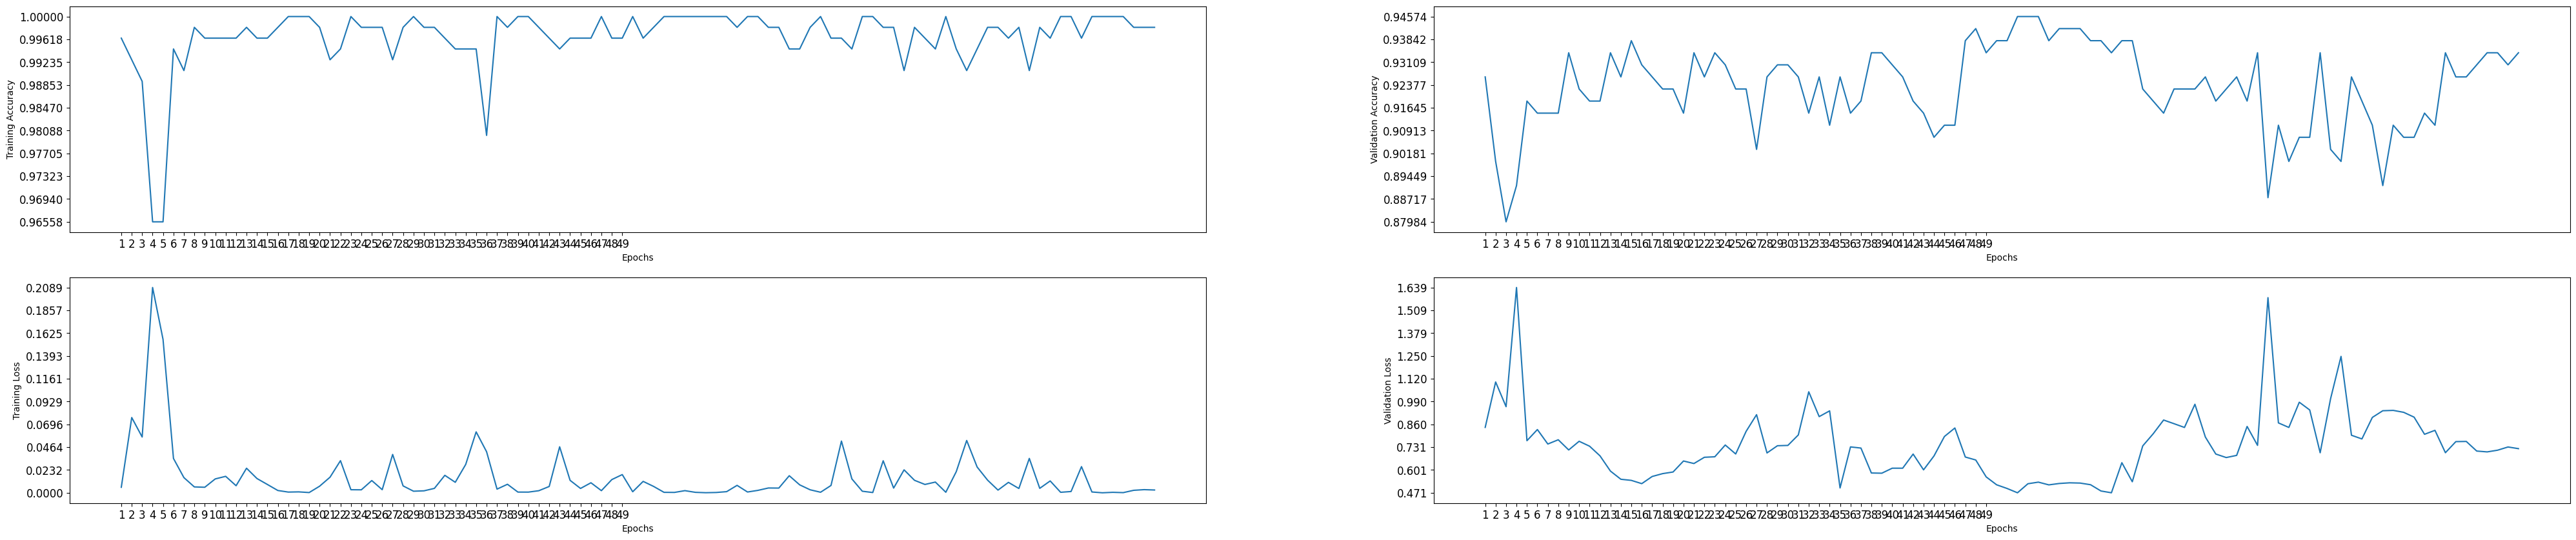

In [ ]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (50, 10) )
train_x = range(1, len(history.history["accuracy"])+1)
train_y = history.history["accuracy"]
train_loss = history.history["loss"]
ax[0,0].plot(train_x, train_y)
ax[0,0].set_xlabel("Epochs")
ax[0,0].set_ylabel("Training Accuracy")
ax[0,0].set_xticks(range(1, 50))
ax[0,0].tick_params(axis = "both", labelsize = 12)
ax[0,0].set_yticks(np.linspace(start = min(train_y), stop = max(train_y), num = 10))

val_x = range(1, len(history.history["val_accuracy"])+1)
val_y = history.history["val_accuracy"]
ax[0,1].plot(val_x , val_y)
ax[0,1].set_xlabel("Epochs")
ax[0,1].set_ylabel("Validation Accuracy")
ax[0,1].set_xticks(range(1, 50))
ax[0,1].set_yticks(np.linspace(start = min(val_y), stop = max(val_y), num = 10))
ax[0,1].tick_params(axis = "both", labelsize = 12)

train_loss = history.history["loss"]
ax[1,0].plot(train_x, train_loss)
ax[1,0].set_xlabel("Epochs")
ax[1,0].set_ylabel("Training Loss")
ax[1,0].set_xticks(range(1, 50))
ax[1,0].tick_params(axis = "both", labelsize = 12)
ax[1,0].set_yticks(np.linspace(start = min(train_loss), stop = max(train_loss), num = 10))

val_loss = history.history["val_loss"]
ax[1,1].plot(train_x, val_loss)
ax[1,1].set_xlabel("Epochs")
ax[1,1].set_ylabel("Validation Loss")
ax[1,1].set_xticks(range(1, 50))
ax[1,1].tick_params(axis = "both", labelsize = 12)
ax[1,1].set_yticks(np.linspace(start = min(val_loss), stop = max(val_loss), num = 10))

plt.show()

## **Optonal Validation **- Validate the Train_ds_encoded shape and data for the first 2 frames in the first vedio.

In [ ]:
for video, label in train_ds_encoded.take(1):
    print("Video tensor data (first 2 frames):")
    # Slice the video tensor to include only the first 2 frames (index 0 and 1)
    print(video[:, :, :8, :, :, :])
    print("\nLabel tensor data:")
    print(label)

Video tensor data (first 2 frames):
tf.Tensor(
[[[[[[0.]
     [0.]
     [0.]
     ...
     [0.]
     [0.]
     [0.]]

    [[0.]
     [0.]
     [0.]
     ...
     [0.]
     [0.]
     [0.]]

    [[0.]
     [0.]
     [0.]
     ...
     [0.]
     [0.]
     [0.]]

    ...

    [[0.]
     [0.]
     [0.]
     ...
     [0.]
     [0.]
     [0.]]

    [[0.]
     [0.]
     [0.]
     ...
     [0.]
     [0.]
     [0.]]

    [[0.]
     [0.]
     [0.]
     ...
     [0.]
     [0.]
     [0.]]]


   [[[0.]
     [0.]
     [0.]
     ...
     [0.]
     [0.]
     [0.]]

    [[0.]
     [0.]
     [0.]
     ...
     [0.]
     [0.]
     [0.]]

    [[0.]
     [0.]
     [0.]
     ...
     [0.]
     [0.]
     [0.]]

    ...

    [[0.]
     [0.]
     [0.]
     ...
     [0.]
     [0.]
     [0.]]

    [[0.]
     [0.]
     [0.]
     ...
     [0.]
     [0.]
     [0.]]

    [[0.]
     [0.]
     [0.]
     ...
     [0.]
     [0.]
     [0.]]]


   [[[0.]
     [0.]
     [0.]
     ...
     [0.]
     [0.]
     [0.]]

    [[0.

In [ ]:
for frames, label in train_ds.take(1):
    print("Raw frames shape:", frames.shape)
    print("Label:", label.numpy())

for spikes, label in train_ds_encoded.take(2):
    # The shape after TTFS encoding and batching is (batch_size, time_steps, frames, H, W, C)
    print("TTFS encoded shape:", spikes.shape)
    print("Label one-hot shape:", label.shape)

    # Apply TTFS encoding and one-hot encoding, then batch and prefetch the datasets
# The ISI_encode function outputs data in the shape (time_steps, frames, H, W, C)
# When batched, the shape becomes (batch_size, time_steps, frames, H, W, C)
# This is the correct input shape for the Conv3D layers, so no further flattening is needed.

Raw frames shape: (10, 10, 50, 50, 1)
Label: 9
TTFS encoded shape: (8, 10, 10, 50, 50, 1)
Label one-hot shape: (8, 10)
TTFS encoded shape: (8, 10, 10, 50, 50, 1)
Label one-hot shape: (8, 10)
